# Overview
This notebook shows how to quicky start using the Hadamard parametrization for optimization over the probability simplex. It accompanies the paper "From the simplex to the sphere: Faster constrained optimization using the Hadamard parametrization"

## Terminology
 - **Hadamard parametrization:** $x = z\cdot z$ where $\cdot$ is the component-wise (or Hadamard) product.
 - **Probability simplex:** $\Delta_{n} \triangleq \{x \in \mathbb{R}^{n}: \ x \geq 0 \text{ and } \sum_{k}x_k = 1 \}$

Thoroughout, we use the notational convention that $x \in \Delta^{n}$ while $z \in \mathbb{S}^n$.

In [413]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
from Riemannian_utils import *
from SimplexProjections import *
from ExpDescentAlg_utils import ExpDescentAlg
from PGD_Linesearch import *
from Riemannian_algs import HadRGD_BB, HadRGD_AW, HadNewton, HadNewton2
from PGD_Variants import PGD
from utils import *

## Setting up the cost function
The next block of code defines the cost function: $f(x) = \left\|Ax - b\right\|_{2}^{2}$. Although it is underdetermined, we choose $b = Ax_{\text{true}}$ so $\min f(x) = 0$.

For simplicity, we define it twice: once in terms of the original variable x and once in terms of the reparametrized variable z. 

In [446]:
n=500
m=50
A1 = np.random.randn(m,5)
A2 = np.random.randn(5,n)
A = A1@A2
x_true = SampleSimplex(n)
b = np.dot(A,x_true)
#s = np.linalg.svd(A, full_matrices=False, compute_uv=False)
#Lipschitz_constant = s[0]

B = np.linalg.inv(A.T @ A)


def cost(x):
    '''
    Least squares loss function.
    '''
    temp = np.dot(A,x) - b
    return np.dot(temp,temp)/2

def cost_grad(x):
    '''
    Gradient of least squares loss function.
    '''
    temp = np.dot(A,x) - b
    return np.dot(A.T,temp)

def cost_hess(x):
    '''
    Hessian of least squares loss function.
    '''
    return A.T @ A

def cost_H(z):
    '''
    Hadamard parametrized least squares cost. Mainly for use with autodiff.
    '''
    return np.sum((A@(z*z) - b)**2)/2

def cost_H_grad(z):
    '''
    Gradient of Hadamard parametrized least squares cost. For use in line search.
    '''
    return 2 * (A.T @ (A@(z*z) - b)) * z


def cost_H_hess(z):
    '''
    Hessian of Hadamard parametrized least squares cost. For use in line search.
    '''
    return 4 * np.diag(z) @ A.T @ A @ np.diag(z) + 2 * np.diag( A.T @ ( A @ (z*z) - b) ) + 2 * np.diag( A.T @ ( A @ (z*z) - b) ) - np.dot(cost_H_grad(z),z)*np.eye(len(z))

def cost_H_hess_inexact(z):
    '''
    Hessian of Hadamard parametrized least squares cost. For use in line search.
    '''
    return 4 * np.diag(z) @ A.T @ A @ np.diag(z) - np.dot(cost_H_grad(z),z)*np.eye(len(z)) # + 2 * np.diag( A.T @ ( A @ (z*z) - b) ) 


def cost_H_invhess(z):
    '''
    Hessian of Hadamard parametrized least squares cost. For use in line search.
    '''

    return np.linalg.pinv(cost_H_hess(z))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Parameters
The next block of code sets parameters.

In [447]:
x0 = SampleSimplex(n)
z0 = np.sqrt(x0)

## Armijo-Wolfe
The next cell implements HadRGD-AW

In [448]:
z = copy.copy(z0)
default_step_size = 10.0
AWOpt = HadRGD_AW(cost_H, cost_H_grad, z, default_step_size)
AWOpt_time = [0]
AWOpt_Error = [cost_H(z)]

In [449]:
start_time = time.time()
for k in range(100):
    err = AWOpt.step()
    AWOpt_time.append(time.time() - start_time)
    AWOpt_Error.append(err)
    print(err)

number of AW iterations= 14
0.2608224308160223
number of AW iterations= 25
0.23576428023283238
number of AW iterations= 25
0.37617901507873835
number of AW iterations= 25
0.7132966809171444
number of AW iterations= 25
1.1385250219039975
number of AW iterations= 13
0.0092283475280926
number of AW iterations= 25
0.012721121889754196
number of AW iterations= 25
0.01871589568000837
number of AW iterations= 25
0.02843612601230498
number of AW iterations= 25
0.042077330940714384
number of AW iterations= 25
0.0638674055669438
number of AW iterations= 25
0.09217570484925008
number of AW iterations= 25
0.1375091330137001
number of AW iterations= 25
0.18873483306447886
number of AW iterations= 25
0.26941030464074395
number of AW iterations= 25
0.3363320495827442
number of AW iterations= 25
0.4372469665768726
number of AW iterations= 25
0.46619469700835664
number of AW iterations= 25
0.5168609531315959
number of AW iterations= 2
0.06812853106048938
number of AW iterations= 25
0.06443744816135175


## Barzilei-Borwein

The next cell implements a Barzilei-Borwein scheme, as described [here](https://scholarship.rice.edu/bitstream/handle/1911/102167/TR10-26.PDF?sequence=1)

In [450]:
alpha_def = 3.0
rho1 = 0.1
beta = 0.5
eta = 0.5
z = copy.copy(z0)
BBOpt_Error = [cost_H(z)]
BBOpt_time = [0]
BBOpt = HadRGD_BB(cost_H, cost_H_grad, alpha_def, rho1, beta, eta, z)

In [451]:
start_time = time.time()
for k in range(50):
    err = BBOpt.step()
    BBOpt_time.append(time.time() - start_time)
    BBOpt_Error.append(err)
    print(err)

1.0181596275444142
0.06050957072625608
0.01647775049173658
0.0018543420909484915
0.00014941824853523364
4.67855010378572e-05
1.9760258203870837e-07
5.066336346514889e-08
2.888184759856991e-08
2.062508024738656e-11
1.3752319396114182e-12
7.634351918360116e-14
2.616641385610121e-16
3.5884297664901653e-17
3.9280223355838756e-20
7.338750707581222e-20
1.504084625164504e-22
1.5886475159393896e-23
2.5564584051311643e-24
4.518897299069484e-29
5.160721878980037e-30
1.0719124217351734e-30
4.893426876823394e-31
4.893426876823394e-31


/Users/cashcherry/Desktop/MINES CLASSES/SPRING 2024/Optimization/Final Project/HadRGD/Riemannian_algs.py:166: RuntimeWarning: invalid value encountered in scalar divide
  alpha_BB = top/bottom


ValueError: x needs to be on the unit sphere

# Newton

In [437]:
z = copy.copy(z0)
default_step_size = 1
NOpt = HadNewton(cost_H, cost_H_grad, cost_H_hess, default_step_size, z)
NOpt_time = [0]
NOpt_Error = [cost_H(z)]

In [438]:
start_time = time.time()
for k in range(50):
    err = NOpt.step()
    NOpt_time.append(time.time() - start_time)
    NOpt_Error.append(err)
    print(err)

0.0019366018573233796
0.0016081065934290975
0.0028281698455621352
0.004992283690702763
0.008827711217812773
0.015562477759759673
0.004510608076176279
0.007417331206505151
0.01213878047853572
0.01184897713219643
0.009111484765276463
0.010573494055394551
0.012677848714952858
0.016535602860163638
0.02513246934840262
0.0460983985429844
0.020110109937998357
0.02821613621914891
0.03914656417228783
0.05146753537786597
0.0635219603905946
0.0624392615785489
0.05375768010904844
0.0451759190983267
0.04132148531903043
0.036546803657663725
0.0320042495657972
0.032951903585105836
0.029118784402253593
0.029404129825585136
0.029846039935488164
0.030568744419221458
0.031804693198389945
0.03399275975638018
0.03795359975748514
0.04513634021865121
0.05766916472695921
0.0771355441430001
0.10089406606674109
0.12102579111651979
0.13326195429334037
0.1402975301292882
0.14491330430865995
0.14811788154374994
0.1502861598860496
0.15169582864012404
0.15259300163300665
0.15316911861876803
0.15355588258343336
0.153

In [454]:
z = copy.copy(z0)
default_step_size = .5
NOpt = HadNewton2(cost_H, cost_H_grad, cost_H_hess, default_step_size, z)
NOpt_time = [0]
NOpt_Error = [cost_H(z)]

In [455]:
start_time = time.time()
for k in range(50):
    err = NOpt.step()
    NOpt_time.append(time.time() - start_time)
    NOpt_Error.append(err)
    print(err)

0.5392162204414098
1.5302284138080895
107.89054367528348
62.84517608593882
40.4612680373647
8.450561541069696
2.440639741465156
1.994256901293064
0.3168002038131203
42.35214602389922
19.068375903393367
32.059129949894924
18.151936427412206
15.611797375785024
11.441265364055232
91.5690309690482
59.43174806211981
35.96151569045787
23.14742040365393
16.412942327664624
14.697640567691979
13.65442766096175
10.655313797536822
9.528923427337412
0.6814869274306347
0.3014192449886454
0.06551462149354195
0.019399179650463942
0.0045611655734947975
0.0011225889921930151
0.0002807239381918238
6.865931962972263e-05
1.7082847050915747e-05
4.266204720113142e-06
1.0664086289733122e-06
2.6655336910467835e-07
6.660864354576204e-08
1.664857573942552e-08
4.162076721863454e-09
1.0405219273628036e-09
2.601335117204934e-10
6.503375821950437e-11
1.6258487158038194e-11
4.064627747043451e-12
1.0161576818138824e-12
2.5403951345975107e-13
6.35098901960215e-14
1.5877474003089165e-14
3.9693686967069e-15
9.9234220559

In [458]:
z = copy.copy(z0)
default_step_size = .5
iNOpt = HadNewton2(cost_H, cost_H_grad, cost_H_hess_inexact, default_step_size, z)
iNOpt_time = [0]
iNOpt_Error = [cost_H(z)]

In [459]:
start_time = time.time()
for k in range(50):
    err = iNOpt.step()
    iNOpt_time.append(time.time() - start_time)
    iNOpt_Error.append(err)
    print(err)

0.5392162204414098
1.5302284138080895
107.89054367528348
23.48892463312211
4.06193989342487
0.9612518715648075
0.23785071196672708
0.059348962079798034
0.014834428731675928
0.0037089606786245514
0.0009273283909384933
0.00023184588012224066
5.796336511096632e-05
1.4491088935646178e-05
3.6228038640871986e-06
9.057049912644082e-07
2.2642672807035637e-07
5.6606737383387226e-08
1.4151694561593592e-08
3.537926228642822e-09
8.844818866469142e-10
2.2112051063751503e-10
5.528011251758473e-11
1.382002815396517e-11
3.4550056583293644e-12
8.637515372715992e-13
2.1593778913586994e-13
5.398442675162272e-14
1.3496107204357197e-14
3.374026861969399e-15
8.435065956999667e-16
2.1087664138726222e-16
5.271914593625864e-17
1.317979377008907e-17
3.2949529508434304e-18
8.237373637362098e-19
2.059341739980882e-19
5.148329416109925e-20
1.2871368246716942e-20
3.2178019573687177e-21
8.044132378231676e-22
2.0114126501345093e-22
4.6002201202005505e-17
1.150055840585225e-17
2.8751381473987913e-18
7.187860261693748e

## PGD on simplex with line search

The next two blocks of code implement both variant of projected gradient descent with line search. 

In [460]:
x = copy.copy(x0)
opt = PGDL_Feasible(cost, cost_grad, CondatProject, x, 0.1, 0.75, 1e-4)
Error_PGDL = [cost(x0)]
Time_PGDL = [0]

In [461]:
start_time = time.time()
for _ in range(100):
    _, err = opt.step()
    Time_PGDL.append(time.time() - start_time)
    Error_PGDL.append(err)
    print(err)

Number of PGDL iterations is 8
0.5964548833845531
Number of PGDL iterations is 9
0.41591919809527056
Number of PGDL iterations is 10
0.22565423879545846
Number of PGDL iterations is 11
0.16328213985880344
Number of PGDL iterations is 10
0.1396649969672735
Number of PGDL iterations is 12
0.061368274358121006
Number of PGDL iterations is 13
0.05007275356038829
Number of PGDL iterations is 13
0.03145491037288717
Number of PGDL iterations is 14
0.025934884172781385
Number of PGDL iterations is 14
0.01199461504873818
Number of PGDL iterations is 16
0.005197078442399536
Number of PGDL iterations is 16
0.004640545120437548
Number of PGDL iterations is 17
0.0030503530598624574
Number of PGDL iterations is 17
0.0020213136317720317
Number of PGDL iterations is 18
0.0016528541434307742
Number of PGDL iterations is 18
0.0010639885815696749
Number of PGDL iterations is 19
0.0007932271904942417
Number of PGDL iterations is 19
0.0005557520889475522
Number of PGDL iterations is 20
0.000364398230850722

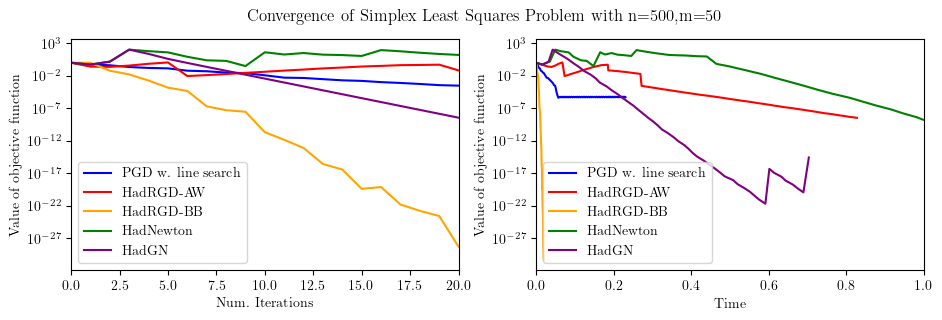

In [462]:
## Now plot the results
fig, ax = plt.subplots(1,2, figsize=(11,3))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax[0].semilogy(Error_PGDL, label="PGD w. line search", color = 'blue')
ax[0].semilogy(AWOpt_Error, label="HadRGD-AW", color = 'red')#, marker = 'o')
ax[0].semilogy(BBOpt_Error, label="HadRGD-BB", color = 'orange')#, marker = 'o')
ax[0].semilogy(NOpt_Error, label="HadNewton", color = 'green')#, marker = 'o')
ax[0].semilogy(iNOpt_Error, label="HadGN", color = 'purple')#, marker = 'o')


ax[0].legend()
ax[0].set_xlabel('Num. Iterations')
ax[0].set_ylabel('Value of objective function')

ax[0].set_xlim(0,20)

ax[1].semilogy(Time_PGDL, Error_PGDL, label="PGD w. line search", color = 'blue')
ax[1].semilogy(AWOpt_time, AWOpt_Error, label="HadRGD-AW", color = 'red')#, marker = 'o')
ax[1].semilogy(BBOpt_time, BBOpt_Error, label="HadRGD-BB", color = 'orange')#, marker = 'o')
ax[1].semilogy(NOpt_time, NOpt_Error, label="HadNewton", color = 'green')#, marker = 'o')
ax[1].semilogy(iNOpt_time, iNOpt_Error, label="HadGN", color = 'purple')#, marker = 'o')


ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value of objective function')

ax[1].set_xlim(0,1)

fig.suptitle('Convergence of Simplex Least Squares Problem with n={},m={}'.format(n,m))

#plt.savefig('Medium_Problem_Convergence.pdf')
plt.show()